In [0]:
df = spark.read.parquet(""")

In [0]:
from pyspark.sql import SparkSession



# Deduplicate rows by 'UniqId_prod' and keep the first occurrence
df = df.dropDuplicates(["UniqId_prod"])

# Show the deduplicated DataFrame
print("Deduplicated DataFrame:")
df.count()

Deduplicated DataFrame:
Out[19]: 60895

In [0]:
from pyspark.ml.feature import Tokenizer, HashingTF, IDF
from pyspark.ml.linalg import Vectors, VectorUDT
from pyspark.sql.functions import avg, collect_list, lit
from pyspark.sql.functions import udf
from pyspark.sql.types import FloatType
import numpy as np

# 1. Tokenization
tokenizer = Tokenizer(inputCol="ProductDescription_prod", outputCol="tokens")
df_tokenized = tokenizer.transform(df_sample)

# 2. TF-IDF Vectorization
hashingTF = HashingTF(inputCol="tokens", outputCol="rawFeatures")
df_tf = hashingTF.transform(df_tokenized)

idf = IDF(inputCol="rawFeatures", outputCol="features")
idfModel = idf.fit(df_tf)
df_tfidf = idfModel.transform(df_tf)

# 3. Calculate the centroid of all TF-IDF vectors
sum_vector_udf = udf(lambda vectors: Vectors.dense(np.sum(vectors, axis=0)), VectorUDT())
df_centroid = df_tfidf.withColumn("vector", df_tfidf["features"].cast(VectorUDT()))
centroid = df_centroid.select(collect_list("vector").alias("vectors")).withColumn("centroid", sum_vector_udf("vectors")).first()["centroid"]

# 4. Broadcast centroid to all worker nodes for efficient computation
broadcast_centroid = sc.broadcast(centroid)

# 5. UDF to calculate cosine similarity to the centroid
def cosine_to_centroid(v):
    v = np.array(v)
    centroid = np.array(broadcast_centroid.value)
    return float(np.dot(v, centroid) / (np.linalg.norm(v) * np.linalg.norm(centroid)))

cosine_to_centroid_udf = udf(cosine_to_centroid, FloatType())
df_sim_to_centroid = df_tfidf.withColumn("similarity_to_centroid", cosine_to_centroid_udf("features"))

# 6. Calculate average similarity to centroid
average_similarity_to_centroid = df_sim_to_centroid.agg(avg("similarity_to_centroid")).collect()[0][0]
print(f"Average Similarity to Centroid: {average_similarity_to_centroid}")


Average Similarity to Centroid: 0.1431971695572138


In [0]:
from pyspark.ml.feature import Tokenizer, HashingTF, IDF
from pyspark.ml.linalg import Vectors, VectorUDT
from pyspark.sql.functions import avg, collect_list
from pyspark.sql.functions import udf
from pyspark.sql.types import FloatType
import numpy as np

# 1. Tokenization
tokenizer = Tokenizer(inputCol="ProductDescription_prod", outputCol="tokens")
df_tokenized = tokenizer.transform(df)

# 2. TF-IDF Vectorization
hashingTF = HashingTF(inputCol="tokens", outputCol="rawFeatures")
df_tf = hashingTF.transform(df_tokenized)

idf = IDF(inputCol="rawFeatures", outputCol="features")
idfModel = idf.fit(df_tf)
df_tfidf = idfModel.transform(df_tf)

# 3. Calculate the centroid of all TF-IDF vectors
sum_vector_udf = udf(lambda vectors: Vectors.dense(np.sum(vectors, axis=0)), VectorUDT())
df_centroid = df_tfidf.withColumn("vector", df_tfidf["features"].cast(VectorUDT()))
centroid = df_centroid.select(collect_list("vector").alias("vectors")).withColumn("centroid", sum_vector_udf("vectors")).first()["centroid"]

# 4. Broadcast centroid to all worker nodes for efficient computation
broadcast_centroid = sc.broadcast(centroid)

# 5. UDF to calculate cosine similarity to the centroid
def cosine_to_centroid(v):
    v = np.array(v)
    centroid = np.array(broadcast_centroid.value)
    return float(np.dot(v, centroid) / (np.linalg.norm(v) * np.linalg.norm(centroid)))

cosine_to_centroid_udf = udf(cosine_to_centroid, FloatType())
df_sim_to_centroid = df_tfidf.withColumn("similarity_to_centroid", cosine_to_centroid_udf("features"))

# 6. Calculate average similarity to centroid
average_similarity_to_centroid = df_sim_to_centroid.agg(avg("similarity_to_centroid")).collect()[0][0]
print(f"Average Similarity to Centroid: {average_similarity_to_centroid}")


In [0]:
df_sim_to_centroid.write.csv("/mnt/igenie-blob01/SandboxLH/similarity_scores.csv", header='True')

In [0]:
from pyspark.sql import functions as F

# Group by brand and calculate average similarity
brand_similarity_df = df_sim_to_centroid.groupBy("ProductBrand_prod").agg(F.avg("similarity_to_centroid").alias("avg_similarity")).orderBy(F.desc("avg_similarity"))

# Display the brands with the highest and lowest average similarity scores
brand_similarity_df.show()


+--------------------+-------------------+
|   ProductBrand_prod|     avg_similarity|
+--------------------+-------------------+
|             Pure NV| 0.5114076733589172|
|             Osensia|0.48708170652389526|
|         L'ANGE HAIR| 0.4405709207057953|
|      Natural Riches|0.43412986397743225|
|                Noah| 0.4338989555835724|
|     ALFAPARF MILANO| 0.4224143922328949|
|            Cliganic|0.42231979966163635|
|       LOVE UR CURLS|0.42051956057548523|
|          Dollylocks| 0.4041193127632141|
|             Saphira| 0.4024561047554016|
|              DIFEEL| 0.4004945158958435|
|     Curls Unleashed|  0.398151695728302|
|THANK GOD IT'S NA...| 0.3916624188423157|
|     Abril Et Nature| 0.3878406286239624|
|       NO FADE FRESH|0.37462371587753296|
|              Solpri| 0.3707782030105591|
|       NO INHIBITION|0.36683419346809387|
|             LINANGE| 0.3662928342819214|
|              SEVICH|0.36231517791748047|
|              Rednow| 0.3503188192844391|
+----------

In [0]:
# Add a new column with the length of each product description
df_with_length = df_sample.withColumn("description_length", F.length("ProductDescription_prod"))

# Group by brand and calculate average length of descriptions
brand_length_df = df_with_length.groupBy("ProductBrand_prod").agg(F.avg("description_length").alias("avg_description_length")).orderBy(F.desc("avg_description_length"))

# Display the brands with the longest and shortest average description lengths
brand_length_df.show()


+--------------------+----------------------+
|   ProductBrand_prod|avg_description_length|
+--------------------+----------------------+
|            Cliganic|                4514.0|
|             Pure NV|                3642.0|
|      Uhuru Naturals|                3483.0|
|Garnier Fructis P...|                3466.0|
|             Osensia|                3369.0|
|           KeraFiber|                3301.0|
|       LOVE UR CURLS|                3186.0|
|          Mad Hippie|                2902.0|
|          Dollylocks|                2895.0|
|         L'ANGE HAIR|                2843.0|
|                WAHL|                2838.0|
|     ALFAPARF MILANO|                2818.0|
|      Natural Riches|                2798.0|
|            TRESemme|    2757.8333333333335|
|                Noah|                2692.0|
|        Keratin Cure|                2678.0|
|            Nutrafol|                2447.0|
|       NO FADE FRESH|                2328.0|
|           Lorddream|            

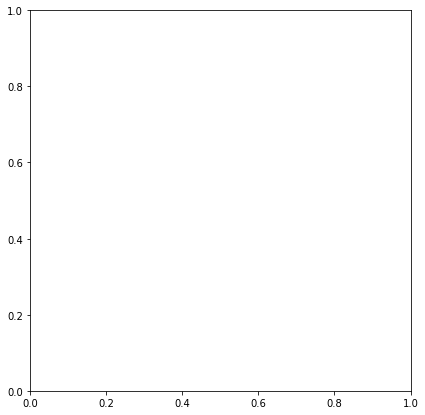

---------------------------------------------------------------------------
AttributeError                            Traceback (most recent call last)
<command-1905638581600586> in <cell line: 8>()
      6 # Plotting average similarity by brand
      7 plt.subplot(1, 2, 1)
----> 8 brand_similarity_df.set_index("ProductBrand_prod")["avg_similarity"].plot(kind="bar", color="skyblue")
      9 plt.title("Average Similarity by Brand")
     10 plt.ylabel("Average Similarity")

/databricks/spark/python/pyspark/sql/dataframe.py in __getattr__(self, name)
   2022         """
   2023         if name not in self.columns:
-> 2024             raise AttributeError(
   2025                 "'%s' object has no attribute '%s'" % (self.__class__.__name__, name)
   2026             )

AttributeError: 'DataFrame' object has no attribute 'set_index'

In [0]:
import matplotlib.pyplot as plt

# Assuming you have converted brand_similarity_df and brand_length_df to pandas DataFrame
plt.figure(figsize=(15,7))

# Plotting average similarity by brand
plt.subplot(1, 2, 1)
brand_similarity_df.set_index("ProductBrand_prod")["avg_similarity"].plot(kind="bar", color="skyblue")
plt.title("Average Similarity by Brand")
plt.ylabel("Average Similarity")
plt.xticks(rotation=45)

# Plotting average description length by brand
plt.subplot(1, 2, 2)
brand_length_df.set_index("ProductBrand_prod")["avg_description_length"].plot(kind="bar", color="salmon")
plt.title("Average Description Length by Brand")
plt.ylabel("Average Length")
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()


In [0]:
# Median similarity by brand
brand_median_similarity = df_sim_to_centroid.groupBy("ProductBrand_prod").agg(F.expr('percentile_approx(similarity_to_centroid, 0.5)').alias('median_similarity'))

# Median description length by brand
brand_median_length = df_with_length.groupBy("ProductBrand_prod").agg(F.expr('percentile_approx(description_length, 0.5)').alias('median_description_length'))


In [0]:
brand_median_similarity.display()

ProductBrand_prod,median_similarity
,0.04565501
(RE)FRESH,0.23240946
/liv/ Nature,0.04565501
ABBA,0.04565501
ACM Laboratoire dermatologique,0.04565501
ACTROL,0.04565501
ADDERENITY,0.04565501
ADWOA BEAUTY,0.26397052
AFRO & RIZO,0.23280373
AG Care,0.04565501


In [0]:
from pyspark.sql import functions as F

# Group by brand and calculate average similarity
brand_similarity_df = df_sim_to_centroid.groupBy("Retailer_prod").agg(F.avg("similarity_to_centroid").alias("avg_similarity")).orderBy(F.desc("avg_similarity"))

# Display the brands with the highest and lowest average similarity scores
brand_similarity_df.show()

+-------------+-------------------+
|Retailer_prod|     avg_similarity|
+-------------+-------------------+
|  sephora.com|0.25984286308288573|
|walgreens.com|0.24153056953634536|
|     ulta.com| 0.2105231602125022|
|      cvs.com|0.19725217487739058|
|   target.com| 0.1898954286042488|
|  walmart.com| 0.1868981814956012|
|   amazon.com|0.09197159397115016|
+-------------+-------------------+



In [0]:
from pyspark.sql.functions import col, udf
from pyspark.sql.types import FloatType, ArrayType, StringType
from pyspark.ml.feature import Tokenizer

# 1. Tokenization
tokenizer = Tokenizer(inputCol="ProductDescription_prod", outputCol="tokens")
df_tokenized = tokenizer.transform(df)

# 2. Convert tokens to sets - using a UDF
def tokens_to_set(tokens):
    return list(set(tokens))

set_udf = udf(tokens_to_set, ArrayType(StringType()))
df_sets = df_tokenized.withColumn("token_sets", set_udf(col("tokens")))

# 3. Calculate Jaccard Similarity - using a UDF
def jaccard_similarity(set1, set2):
    set1, set2 = set(set1), set(set2)
    intersection_len = len(set1.intersection(set2))
    union_len = len(set1.union(set2))
    
    if union_len == 0:
        return 0.0
    
    return float(intersection_len) / union_len

jaccard_udf = udf(jaccard_similarity, FloatType())
df_cross = df_sets.crossJoin(df_sets.withColumnRenamed("token_sets", "token_sets_2"))

df_jaccard = df_cross.withColumn("jaccard_similarity", jaccard_udf("token_sets", "token_sets_2"))

df_jaccard.select("ProductDescription_prod", "jaccard_similarity").show()


In [0]:
from pyspark.ml.feature import Tokenizer, Word2Vec
from pyspark.sql.functions import col, udf
from pyspark.sql.types import FloatType
from pyspark.ml.linalg import Vectors, VectorUDT
import numpy as np

# 1. Tokenization
tokenizer = Tokenizer(inputCol="ProductDescription_prod", outputCol="tokens")
df_tokenized = tokenizer.transform(df)

# 2. Generate Word Embeddings using Word2Vec
word2Vec = Word2Vec(vectorSize=100, minCount=5, inputCol="tokens", outputCol="word2vec")
model = word2Vec.fit(df_tokenized)
df_word2vec = model.transform(df_tokenized)

# 3. UDF for Cosine Similarity
def cosine_similarity(v1, v2):
    v1 = np.array(v1.toArray())
    v2 = np.array(v2.toArray())
    return float(np.dot(v1, v2) / (np.linalg.norm(v1) * np.linalg.norm(v2)))

cosine_similarity_udf = udf(cosine_similarity, FloatType())

# Cross-join to get pairwise combinations
df_cross = df_word2vec.crossJoin(df_word2vec.withColumnRenamed("word2vec", "word2vec_2"))

# Calculate pairwise similarities
df_similarities = df_cross.withColumn("similarity", cosine_similarity_udf("word2vec", "word2vec_2"))

df_similarities.select("ProductDescription_prod", "similarity").show()

